# EastRiver watershed

In [45]:
watershed = 'EastRiver'

In [48]:
# import packages
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import os
#import warnings
#warnings.filterwarnings('ignore')

import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC

In [52]:
# specify the path to the helper function
path_to_helper = os.getcwd().rsplit('/',2)[0] + '/Functions'

# insert this path to system
sys.path.insert(1, path_to_helper)

# import this helper function
from Pipeline_helpers import *

In [4]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,400), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-5,50), ### avoid unreasonable records
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### 1. Discharge

In [5]:
### read data

In [6]:
path =  os.getcwd().rsplit('/',1)[0]+'/RawData/' + 'Discharge_raw_data/'

In [7]:
Avery_discharge = pd.read_csv(path + 'Avery_discharge.csv',header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Avery_discharge = Avery_discharge.drop(Avery_discharge.columns[[1,2]],axis=1)
Avery_discharge.columns = ['Avery_Discharge']

Bradley_discharge = pd.read_csv(path + 'Bradley_discharge.csv',header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Bradley_discharge = Bradley_discharge.drop(Bradley_discharge.columns[[1,2]],axis=1)
Bradley_discharge.columns = ['Bradley_Discharge']

Copper_discharge = pd.read_csv(path + 'Copper_discharge.csv',header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Copper_discharge = Copper_discharge.drop(Copper_discharge.columns[[1,2]],axis=1)
Copper_discharge.columns=['Copper_Discharge']

East_above_Quigley_discharge = pd.read_csv(path + 'East_above_Quigley_discharge.csv',header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
East_above_Quigley_discharge = East_above_Quigley_discharge.drop(East_above_Quigley_discharge.columns[[1,2]],axis=1)
East_above_Quigley_discharge.columns=['EastQuigley_Discharge']

Gothic_discharge = pd.read_csv(path + 'Gothic_discharge.csv',header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Gothic_discharge = Gothic_discharge.drop(Gothic_discharge.columns[[1,2]],axis=1)
Gothic_discharge.columns=['Gothic_Discharge']

Marmot_discharge = pd.read_csv(path + 'Marmot_discharge.csv',header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Marmot_discharge = Marmot_discharge.drop(Marmot_discharge.columns[[1,2]],axis=1)
Marmot_discharge.columns=['Marmot_Discharge']

PH_ISCO_discharge = pd.read_csv(path + 'PH_ISCO_discharge.csv',header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
PH_ISCO_18 = pd.read_csv(path + 'PH_ISCO_2018.csv',header = 0,index_col = 'Standard Time',parse_dates = True, infer_datetime_format = True)
PH_ISCO_18 = PH_ISCO_18.drop(['WY day'], axis=1)
PH_ISCO_18 = PH_ISCO_18.rename(columns={'Q m3/s': 'PHISCO_Discharge'})
PH_ISCO_discharge = PH_ISCO_discharge.drop(PH_ISCO_discharge.columns[1],axis = 1)
PH_ISCO_discharge = PH_ISCO_discharge.rename(columns={'value': 'PHISCO_Discharge'})
PHISCO_discharge = PH_ISCO_discharge.append(PH_ISCO_18, sort = False)
PHISCO_discharge = PHISCO_discharge[~PHISCO_discharge.index.duplicated(keep='first')]
PHISCO_discharge.drop(PHISCO_discharge.index[16775],inplace = True)
PHISCO_discharge.columns=['PHISCO_Discharge']

Quigley_discharge = pd.read_csv(path + 'Quigley_discharge.csv',header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Quigley_discharge = Quigley_discharge.drop(Quigley_discharge.columns[[1,2]],axis=1)
Quigley_discharge.columns=['Quigley_Discharge']

Rock_discharge = pd.read_csv(path + 'Rock_discharge.csv',header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Rock_discharge = Rock_discharge.drop(Rock_discharge.columns[[1,2]],axis=1)
Rock_discharge.columns=['Rock_Discharge']

Rustlers_discharge = pd.read_csv(path + 'Rustlers_discharge.csv',header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Rustlers_discharge = Rustlers_discharge.drop(Rustlers_discharge.columns[[1,2]],axis=1)
Rustlers_discharge.columns=['Rustlers_Discharge']

In [8]:
df_lst = [Avery_discharge,Bradley_discharge,Copper_discharge,East_above_Quigley_discharge,
         Gothic_discharge ,Marmot_discharge,PHISCO_discharge,Quigley_discharge,Rock_discharge,Rustlers_discharge]
for df in df_lst:  
    df = threC(df,'Discharge') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index)
    df.index.rename('DateTime',inplace=True)
    display(df.head(2))
    print(df.index[0],df.index[-1])

prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

,Avery_Discharge
DateTime,
2015-09-06 17:20:00,0.648962
2015-09-06 18:00:00,0.626053


2015-09-06 17:20:00 2016-10-14 00:00:00


,Bradley_Discharge
DateTime,
2015-09-01 03:00:00,0.070367
2015-09-01 04:00:00,0.069123


2015-09-01 03:00:00 2016-10-12 23:00:00


,Copper_Discharge
DateTime,
2015-09-06 17:20:00,0.648962
2015-09-06 18:00:00,0.626053


2015-09-06 17:20:00 2016-10-14 00:00:00


,EastQuigley_Discharge
DateTime,
2014-09-01 15:00:00,0.385430
2014-09-02 15:00:00,0.382729


2014-09-01 15:00:00 2016-10-13 00:00:00


,Gothic_Discharge
DateTime,
2014-09-01 02:00:00,0.107281
2014-09-01 03:00:00,0.110065


2014-09-01 02:00:00 2016-10-14 00:00:00


,Marmot_Discharge
DateTime,
2014-09-01 02:00:00,0.002298
2014-09-01 03:00:00,0.002383


2014-09-01 02:00:00 2016-10-13 23:00:00


,PHISCO_Discharge
DateTime,
2014-05-01 15:00:00,4.56823
2014-05-02 15:00:00,4.54378


2014-05-01 15:00:00 2018-10-16 15:10:00


,Quigley_Discharge
DateTime,
2014-09-01 15:00:00,0.013857
2014-09-02 15:00:00,0.013037


2014-09-01 15:00:00 2016-10-13 00:00:00


,Rock_Discharge
DateTime,
2014-10-01 03:00:00,0.031218
2014-10-01 04:00:00,0.031256


2014-10-01 03:00:00 2016-10-14 00:00:00


,Rustlers_Discharge
DateTime,
2015-10-19 19:40:00,0.132581
2015-10-19 20:00:00,0.126394


2015-10-19 19:40:00 2016-10-13 00:00:00
The final table is:


,Avery_Discharge,Bradley_Discharge,Copper_Discharge,EastQuigley_Discharge,Gothic_Discharge,Marmot_Discharge,PHISCO_Discharge,Quigley_Discharge,Rock_Discharge,Rustlers_Discharge
2014-05-01,NaN,NaN,NaN,NaN,NaN,NaN,4.56823,NaN,NaN,NaN
2014-05-02,NaN,NaN,NaN,NaN,NaN,NaN,4.54378,NaN,NaN,NaN


,Avery_Discharge,Bradley_Discharge,Copper_Discharge,EastQuigley_Discharge,Gothic_Discharge,Marmot_Discharge,PHISCO_Discharge,Quigley_Discharge,Rock_Discharge,Rustlers_Discharge
2018-10-15,NaN,NaN,NaN,NaN,NaN,NaN,0.684592,NaN,NaN,NaN
2018-10-16,NaN,NaN,NaN,NaN,NaN,NaN,0.741103,NaN,NaN,NaN


Avery_Discharge
Bradley_Discharge
Copper_Discharge
EastQuigley_Discharge
Gothic_Discharge
Marmot_Discharge
PHISCO_Discharge
Quigley_Discharge
Rock_Discharge
Rustlers_Discharge


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

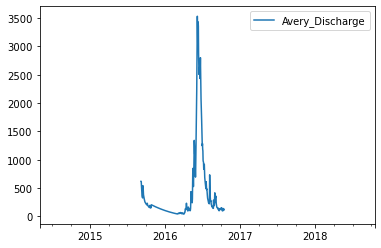

<Figure size 432x288 with 0 Axes>

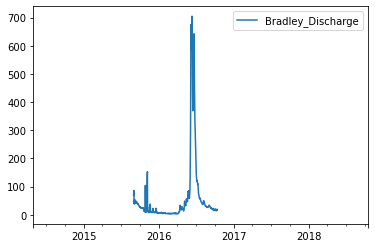

<Figure size 432x288 with 0 Axes>

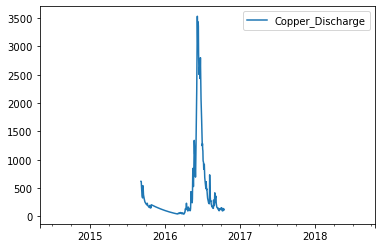

<Figure size 432x288 with 0 Axes>

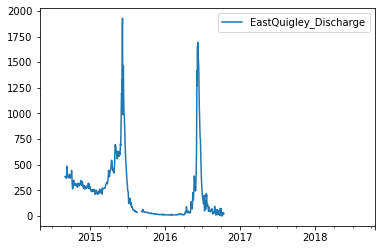

<Figure size 432x288 with 0 Axes>

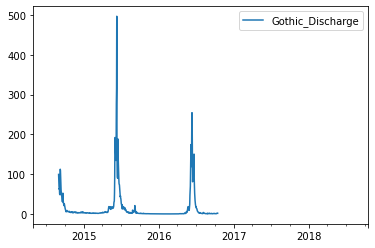

<Figure size 432x288 with 0 Axes>

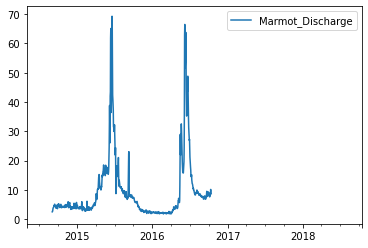

<Figure size 432x288 with 0 Axes>

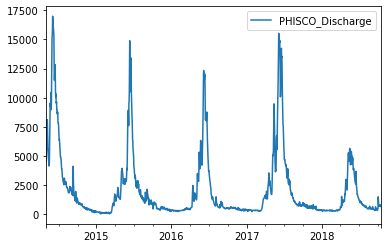

<Figure size 432x288 with 0 Axes>

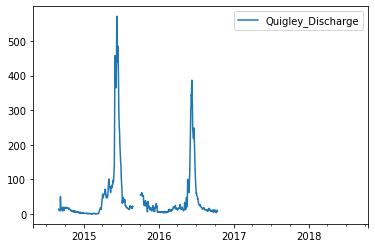

<Figure size 432x288 with 0 Axes>

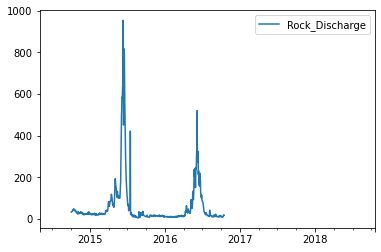

<Figure size 432x288 with 0 Axes>

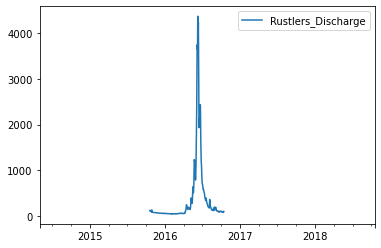

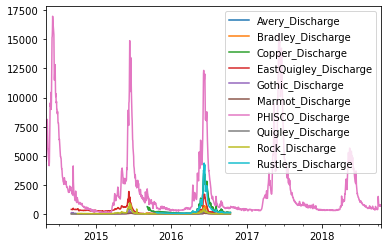

In [9]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*1000  # convert to the right unit(m3/s to L/s)
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge') 
Discharge = copy.deepcopy(df)
Discharge.plot()

### Meterology data

### 2. Precipitation

In [10]:
path=os.getcwd().rsplit('/',1)[0]+'/RawData/' + 'Precipitation_raw_data/'
path 

'/Volumes/GoogleDrive/My Drive/ESDL/ChosenPaper/CatchmentData/1-EastRiver/RawData/Precipitation_raw_data/'

In [11]:
data00 = pd.read_csv(path + 'NLDAS_EastRiver_4YR_0_0.csv',
                    header = 0,index_col = 'TIME',parse_dates = True, infer_datetime_format = True)
data00 = data00.drop(data00.columns[[0,1,2,3,4,6,7,8,9,10]],axis=1)

data01 = pd.read_csv(path + 'NLDAS_EastRiver_4YR_0_1.csv',
                    header = 0,index_col = 'TIME',parse_dates = True, infer_datetime_format = True)
data01 = data01.drop(data01.columns[[0,1,2,3,4,6,7,8,9,10]],axis=1)

data02 = pd.read_csv(path + 'NLDAS_EastRiver_4YR_0_2.csv',
                    header = 0,index_col = 'TIME',parse_dates = True, infer_datetime_format = True)
data02 = data02.drop(data02.columns[[0,1,2,3,4,6,7,8,9,10]],axis=1)

#####
data10 = pd.read_csv(path + 'NLDAS_EastRiver_4YR_1_0.csv',
                    header = 0,index_col = 'TIME',parse_dates = True, infer_datetime_format = True)
data10 = data10.drop(data10.columns[[0,1,2,3,4,6,7,8,9,10]],axis=1)

data11 = pd.read_csv(path + 'NLDAS_EastRiver_4YR_1_1.csv',
                    header = 0,index_col = 'TIME',parse_dates = True, infer_datetime_format = True)
data11 = data11.drop(data11.columns[[0,1,2,3,4,6,7,8,9,10]],axis=1)

data12 = pd.read_csv(path + 'NLDAS_EastRiver_4YR_1_2.csv',
                    header = 0,index_col = 'TIME',parse_dates = True, infer_datetime_format = True)
data12 = data12.drop(data12.columns[[0,1,2,3,4,6,7,8,9,10]],axis=1)

#####
data20 = pd.read_csv(path + 'NLDAS_EastRiver_4YR_2_0.csv',
                    header = 0,index_col = 'TIME',parse_dates = True, infer_datetime_format = True)
data20 = data20.drop(data20.columns[[0,1,2,3,4,6,7,8,9,10]],axis=1)

data21 = pd.read_csv(path + 'NLDAS_EastRiver_4YR_2_1.csv',
                    header = 0,index_col = 'TIME',parse_dates = True, infer_datetime_format = True)
data21 = data21.drop(data21.columns[[0,1,2,3,4,6,7,8,9,10]],axis=1)

data22 = pd.read_csv(path + 'NLDAS_EastRiver_4YR_2_2.csv',
                    header = 0,index_col = 'TIME',parse_dates = True, infer_datetime_format = True)
data22 = data22.drop(data22.columns[[0,1,2,3,4,6,7,8,9,10]],axis=1)


In [12]:
df_lst = [data00, data01,data02,data10,data11,data12,data20,data21,data22]
column_name = ['00_Precipitation','01_Precipitation','02_Precipitation',
              '10_Precipitation','11_Precipitation','12_Precipitation',
              '20_Precipitation','21_Precipitation','22_Precipitation']
for i,df in enumerate(df_lst):  
    col=column_name[i]
    df.columns=[col]
    df['date'] = [pd.to_datetime(str(k), format='%Y%m%d%H', errors='ignore') for k in df.index]
    df.index = df['date']
    df.drop(['date'], axis =1,inplace = True)
    df = threC(df,'Precipitation') # modify the dataframe and set unphysical values to NAN
    df.index.rename('DateTime',inplace=True)
    display(df.head(2))
    print(df.index[0],df.index[-1])

prep = aggre_and_comb_daily(df_lst, axis=1, func = "sum") 

,00_Precipitation
DateTime,
2014-10-01 00:00:00,0.1660
2014-10-01 01:00:00,0.1884


2014-10-01 00:00:00 2018-09-30 23:00:00


,01_Precipitation
DateTime,
2014-10-01 00:00:00,0.1486
2014-10-01 01:00:00,0.1442


2014-10-01 00:00:00 2018-09-30 23:00:00


,02_Precipitation
DateTime,
2014-10-01 00:00:00,0.1290
2014-10-01 01:00:00,0.1238


2014-10-01 00:00:00 2018-09-30 23:00:00


,10_Precipitation
DateTime,
2014-10-01 00:00:00,0.1538
2014-10-01 01:00:00,0.1802


2014-10-01 00:00:00 2018-09-30 23:00:00


,11_Precipitation
DateTime,
2014-10-01 00:00:00,0.1044
2014-10-01 01:00:00,0.1712


2014-10-01 00:00:00 2018-09-30 23:00:00


,12_Precipitation
DateTime,
2014-10-01 00:00:00,0.0870
2014-10-01 01:00:00,0.1146


2014-10-01 00:00:00 2018-09-30 23:00:00


,20_Precipitation
DateTime,
2014-10-01 00:00:00,0.1126
2014-10-01 01:00:00,0.0878


2014-10-01 00:00:00 2018-09-30 23:00:00


,21_Precipitation
DateTime,
2014-10-01 00:00:00,0.2016
2014-10-01 01:00:00,0.1676


2014-10-01 00:00:00 2018-09-30 23:00:00


,22_Precipitation
DateTime,
2014-10-01 00:00:00,0.1786
2014-10-01 01:00:00,0.1182


2014-10-01 00:00:00 2018-09-30 23:00:00
The final table is:


,00_Precipitation,01_Precipitation,02_Precipitation,10_Precipitation,11_Precipitation,12_Precipitation,20_Precipitation,21_Precipitation,22_Precipitation
2014-10-01,5.2054,5.5608,0.8628,9.2788,6.9132,7.6684,15.5408,11.057,8.6182
2014-10-02,1.2792,0.0684,6.4052,0.308,0.016,0.4204,0.2276,0.0048,0.2368


,00_Precipitation,01_Precipitation,02_Precipitation,10_Precipitation,11_Precipitation,12_Precipitation,20_Precipitation,21_Precipitation,22_Precipitation
2018-09-29,0,0,0,0,0,0,0,0,0
2018-09-30,0,0,0,0.0092,0.0156,0.0084,0.0996,0.164,0.09


00_Precipitation
01_Precipitation
02_Precipitation
10_Precipitation
11_Precipitation
12_Precipitation
20_Precipitation
21_Precipitation
22_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

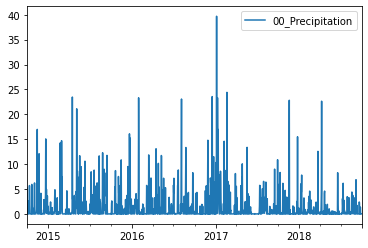

<Figure size 432x288 with 0 Axes>

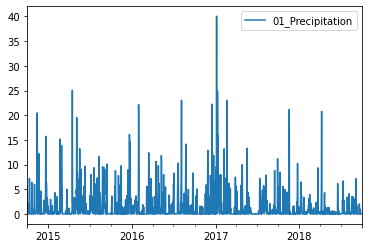

<Figure size 432x288 with 0 Axes>

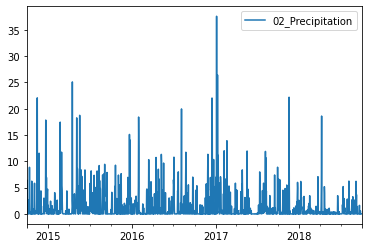

<Figure size 432x288 with 0 Axes>

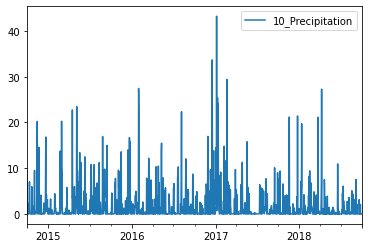

<Figure size 432x288 with 0 Axes>

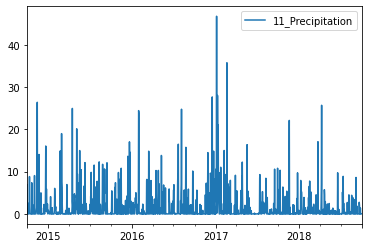

<Figure size 432x288 with 0 Axes>

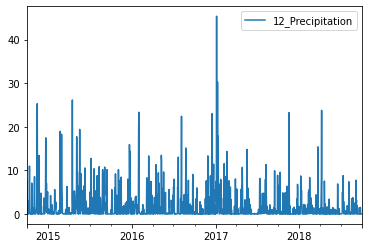

<Figure size 432x288 with 0 Axes>

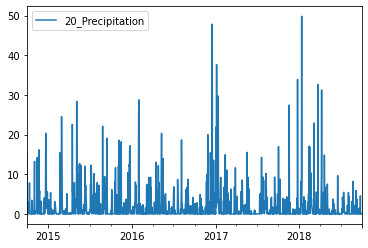

<Figure size 432x288 with 0 Axes>

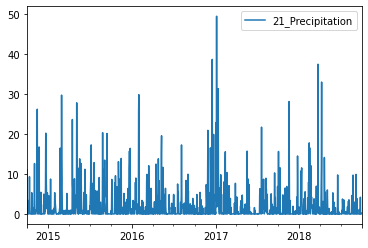

<Figure size 432x288 with 0 Axes>

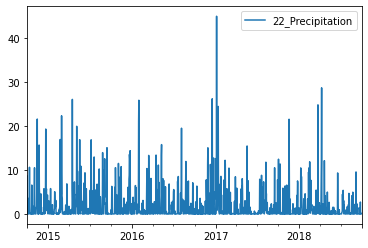

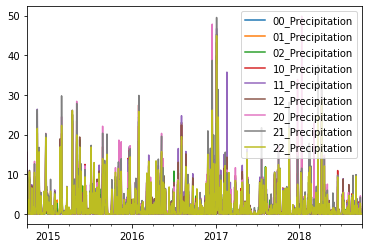

In [13]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'Precipitation')     
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. Air Temperature

In [14]:
path =os.getcwd().rsplit('/',1)[0]+'/RawData/' + 'AirTemperature_raw_data/'

In [15]:
castnet_airtemperature = pd.read_csv(path + 'castnet_airtemperature.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
castnet_airtemperature = castnet_airtemperature.drop(castnet_airtemperature.columns[[1,2]],axis=1)

ER_CSMWS_airtemperature = pd.read_csv(path + 'ER_CSMWS_airtemperature.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
ER_CSMWS_airtemperature = ER_CSMWS_airtemperature.drop(ER_CSMWS_airtemperature.columns[[1,2]],axis=1)

Judd_Falls_airtemperature = pd.read_csv(path + 'Judd_Falls_airtemperature.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Judd_Falls_airtemperature = Judd_Falls_airtemperature.drop(Judd_Falls_airtemperature.columns[[1,2]],axis=1)

Kettle_Ponds_airtemperature = pd.read_csv(path + 'Kettle_Ponds_airtemperature.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Kettle_Ponds_airtemperature = Kettle_Ponds_airtemperature.drop(Kettle_Ponds_airtemperature.columns[[1,2]],axis=1)


In [16]:
df_lst = [castnet_airtemperature , ER_CSMWS_airtemperature, Judd_Falls_airtemperature, Kettle_Ponds_airtemperature]
column_name = ['Castnet_AirTemperature','ERCSMWS_AirTemperature',
               'JuddFalls_AirTemperature','KettlePonds_AirTemperature']
for i,df in enumerate(df_lst):  
    print(i)
    col=column_name[i]
    df.columns=[col]
    df['date'] = [pd.to_datetime(str(k), format='%Y%m%d%H', errors='ignore') for k in df.index]
    df.index = df['date']
    df.index=pd.to_datetime(df.index)
    df.drop(['date'], axis =1,inplace = True)
    df = threC(df,'AirTemperature') # modify the dataframe and set unphysical values to NAN
    df.index.rename('DateTime',inplace=True)
    display(df.head(2))
    print(df.index[0],df.index[-1])

prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

0


,Castnet_AirTemperature
DateTime,
2015-08-31 00:00:00,10.03
2015-08-31 01:00:00,9.73


2015-08-31 00:00:00 2016-01-06 02:00:00
1


,ERCSMWS_AirTemperature
DateTime,
2016-09-25 14:50:00,9.070
2016-09-25 15:00:00,10.065


2016-09-25 14:50:00 2018-09-13 00:00:00
2


,JuddFalls_AirTemperature
DateTime,
2015-09-29 20:40:00,13.540000
2015-09-29 21:00:00,12.813333


2015-09-29 20:40:00 2018-10-03 00:00:00
3


,KettlePonds_AirTemperature
DateTime,
2015-09-28 17:10:00,19.858000
2015-09-28 18:00:00,20.016667


2015-09-28 17:10:00 2018-10-03 00:00:00
['Castnet_AirTemperature', datetime.date(2015, 12, 24)]
nan ratio is 0.041666666666666664 , groupby value is -14.991304273182607
['Castnet_AirTemperature', datetime.date(2015, 12, 27)]
nan ratio is 0.08333333333333333 , groupby value is -9.670000032939544
['ERCSMWS_AirTemperature', datetime.date(2016, 12, 4)]
nan ratio is 0.08333333333333333 , groupby value is -11.315507575757575
['ERCSMWS_AirTemperature', datetime.date(2016, 12, 20)]
nan ratio is 0.041666666666666664 , groupby value is -14.20273188405797
['ERCSMWS_AirTemperature', datetime.date(2017, 12, 22)]
nan ratio is 0.08333333333333333 , groupby value is -11.679681818181818
['JuddFalls_AirTemperature', datetime.date(2016, 12, 18)]
nan ratio is 0.041666666666666664 , groupby value is -15.844521739130437
['JuddFalls_AirTemperature', datetime.date(2017, 1, 28)]
nan ratio is 0.041666666666666664 , groupby value is -12.126753623188405
['KettlePonds_AirTemperature', datetime.date(2015, 12, 26)]


,Castnet_AirTemperature,ERCSMWS_AirTemperature,JuddFalls_AirTemperature,KettlePonds_AirTemperature
2015-08-31,11.6015,NaN,NaN,NaN
2015-09-01,11.7057,NaN,NaN,NaN


,Castnet_AirTemperature,ERCSMWS_AirTemperature,JuddFalls_AirTemperature,KettlePonds_AirTemperature
2018-10-02,NaN,NaN,7.29667,7.48244
2018-10-03,NaN,NaN,7.212,7.986


Castnet_AirTemperature
ERCSMWS_AirTemperature
JuddFalls_AirTemperature
KettlePonds_AirTemperature


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

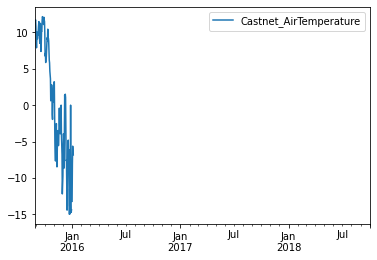

<Figure size 432x288 with 0 Axes>

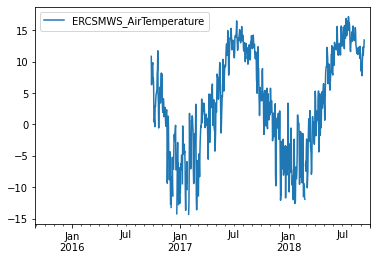

<Figure size 432x288 with 0 Axes>

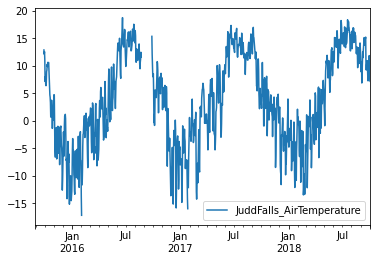

<Figure size 432x288 with 0 Axes>

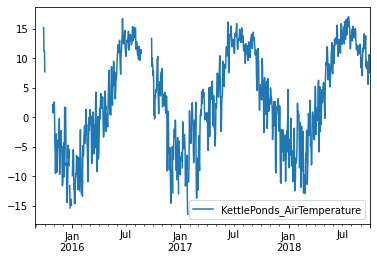

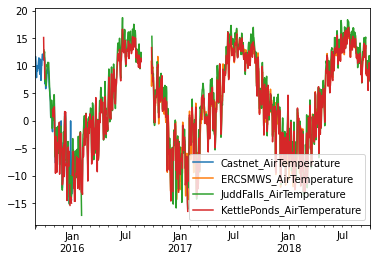

In [17]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Air Temperature unit should be Degree celsius

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'AirTemperature')   
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()

### 4. Solar Radiation
### None

### 5. Relative Humidity

In [18]:
path =os.getcwd().rsplit('/',1)[0] +'/RawData/' + 'Humidity_raw_data/'

In [19]:
ER_CSMWS_humidity = pd.read_csv(path + 'ER_CSMWS_humidity.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
ER_CSMWS_humidity = ER_CSMWS_humidity.drop(ER_CSMWS_humidity.columns[[1,2]],axis=1)

Judd_Falls_humidity = pd.read_csv(path + 'Judd_Falls_humidity.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Judd_Falls_humidity = Judd_Falls_humidity.drop(Judd_Falls_humidity.columns[[1,2]],axis=1)


In [20]:
df_lst = [ER_CSMWS_humidity,Judd_Falls_humidity]
column_name = ['ERCSMWS_RelativeHumidity','JuddFalls_RelativeHumidity']
for i,df in enumerate(df_lst):  
    print(i)
    col=column_name[i]
    df.columns=[col]
    df['date'] = [pd.to_datetime(str(k), format='%Y%m%d%H', errors='ignore') for k in df.index]
    df.index = df['date']
    df.index=pd.to_datetime(df.index)
    df.drop(['date'], axis =1,inplace = True)
    df = threC(df,'RelativeHumidity') # modify the dataframe and set unphysical values to NAN
    df.index.rename('DateTime',inplace=True)
    display(df.head(2))
    print(df.index[0],df.index[-1])

prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

0


,ERCSMWS_RelativeHumidity
DateTime,
2016-09-25 14:50:00,41.100000
2016-09-25 15:00:00,38.616667


2016-09-25 14:50:00 2018-09-13 00:00:00
1


,JuddFalls_RelativeHumidity
DateTime,
2015-09-29 20:40:00,39.600000
2015-09-29 21:00:00,41.576667


2015-09-29 20:40:00 2018-10-03 00:00:00
The final table is:


,ERCSMWS_RelativeHumidity,JuddFalls_RelativeHumidity
2015-09-29,NaN,41.1333
2015-09-30,NaN,45.4027


,ERCSMWS_RelativeHumidity,JuddFalls_RelativeHumidity
2018-10-02,NaN,91.6604
2018-10-03,NaN,96.7


ERCSMWS_RelativeHumidity
JuddFalls_RelativeHumidity


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

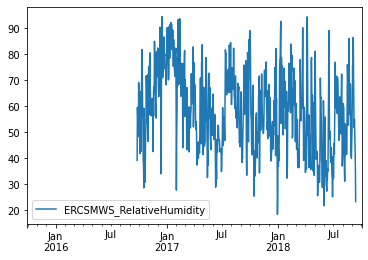

<Figure size 432x288 with 0 Axes>

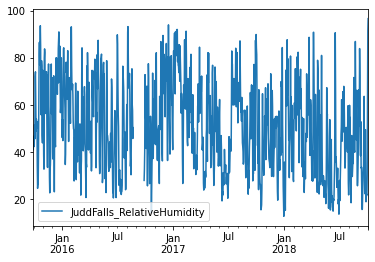

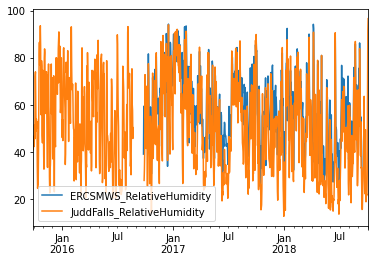

In [21]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! RelativeHumidity unit should be %

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'RelativeHumidity')  
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()

In [22]:
# 6.WindDirection

In [23]:
# 7.WindSpeed

In [24]:
# 8.SWE

### 9.SnowDepth

In [25]:
path =os.getcwd().rsplit('/',1)[0]+'/RawData/' + 'SnowDepth_raw_data/'

In [26]:
ER_CSMWS_snowdepth = pd.read_csv(path + 'ER_CSMWS_snowdepth.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
ER_CSMWS_snowdepth = ER_CSMWS_snowdepth.drop(ER_CSMWS_snowdepth.columns[[1,2]],axis=1)

Judd_Falls_snowdepth = pd.read_csv(path + 'Judd_Falls_snowdepth.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Judd_Falls_snowdepth = Judd_Falls_snowdepth.drop(Judd_Falls_snowdepth.columns[[1,2]],axis=1)

Kettle_Ponds_snowdepth = pd.read_csv(path + 'Kettle_Ponds_snowdepth.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Kettle_Ponds_snowdepth = Kettle_Ponds_snowdepth.drop(Kettle_Ponds_snowdepth.columns[[1,2]],axis=1)

In [27]:
SD_list = [ER_CSMWS_snowdepth, Judd_Falls_snowdepth, Kettle_Ponds_snowdepth]
column_name = ['ERCSMWS_SnowDepth','JuddFalls_SnowDepth','KettlePonds_SnowDepth']
for i,df in enumerate(df_lst):  
    print(i)
    col=column_name[i]
    df.columns=[col]
    df['date'] = [pd.to_datetime(str(k), format='%Y%m%d%H', errors='ignore') for k in df.index]
    df.index = df['date']
    df.index=pd.to_datetime(df.index)
    df.drop(['date'], axis =1,inplace = True)
    df = threC(df,'SnowDepth') # modify the dataframe and set unphysical values to NAN
    df.index.rename('DateTime',inplace=True)
    display(df.head(2))
    print(df.index[0],df.index[-1])

prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

0


,ERCSMWS_SnowDepth
DateTime,
2016-09-25 14:50:00,41.100000
2016-09-25 15:00:00,38.616667


2016-09-25 14:50:00 2018-09-13 00:00:00
1


,JuddFalls_SnowDepth
DateTime,
2015-09-29 20:40:00,39.600000
2015-09-29 21:00:00,41.576667


2015-09-29 20:40:00 2018-10-03 00:00:00
The final table is:


,ERCSMWS_SnowDepth,JuddFalls_SnowDepth
2015-09-29,NaN,41.1333
2015-09-30,NaN,45.4027


,ERCSMWS_SnowDepth,JuddFalls_SnowDepth
2018-10-02,NaN,91.6604
2018-10-03,NaN,96.7


ERCSMWS_SnowDepth
JuddFalls_SnowDepth


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

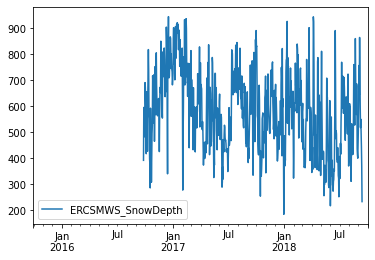

<Figure size 432x288 with 0 Axes>

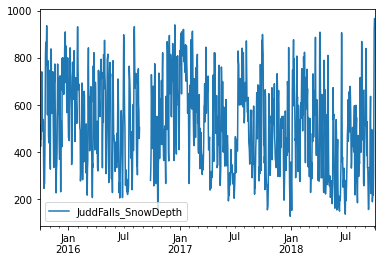

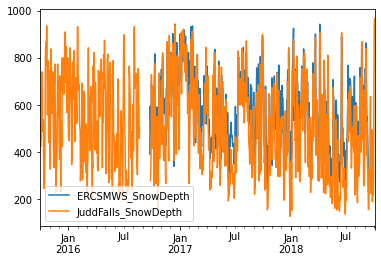

In [28]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Snowdepth unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*10  # convert to the right unit to mm
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'SnowDepth')  
SnowDepth = copy.deepcopy(df)
SnowDepth.plot()

In [29]:
# 10.VaporPressure

### 11. SoilMoisture

In [30]:
path =os.getcwd().rsplit('/',1)[0]+'/RawData/' + 'SoilMoisture_raw_data/'

In [31]:
Judd_Falls_moisture_508 = pd.read_csv(path + 'Judd_Falls_soilmoisture_5.08.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Judd_Falls_moisture_508 = Judd_Falls_moisture_508.drop(Judd_Falls_moisture_508.columns[[1,2]],axis=1)

Judd_Falls_moisture_2540 = pd.read_csv(path + 'Judd_Falls_soilmoisture_25.40.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Judd_Falls_moisture_2540 = Judd_Falls_moisture_2540.drop(Judd_Falls_moisture_2540.columns[[1,2]],axis=1)

Judd_Falls_moisture_5080 = pd.read_csv(path + 'Judd_Falls_soilmoisture_50.80.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Judd_Falls_moisture_5080 = Judd_Falls_moisture_5080.drop(Judd_Falls_moisture_5080.columns[[1,2]],axis=1)


Kettle_Ponds_moisture_508 = pd.read_csv(path + 'Kettle_Ponds_soilmoisture_5.08.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Kettle_Ponds_moisture_508 = Kettle_Ponds_moisture_508.drop(Kettle_Ponds_moisture_508.columns[[1,2]],axis=1)

Kettle_Ponds_moisture_2540 = pd.read_csv(path + 'Kettle_Ponds_soilmoisture_25.40.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Kettle_Ponds_moisture_2540 = Kettle_Ponds_moisture_2540.drop(Kettle_Ponds_moisture_2540.columns[[1,2]],axis=1)

Kettle_Ponds_moisture_5080 = pd.read_csv(path + 'Kettle_Ponds_soilmoisture_50.80.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
Kettle_Ponds_moisture_5080 = Kettle_Ponds_moisture_5080.drop(Kettle_Ponds_moisture_5080.columns[[1,2]],axis=1)



In [32]:
df_lst = [Judd_Falls_moisture_508, Judd_Falls_moisture_2540, Judd_Falls_moisture_5080,
          Kettle_Ponds_moisture_508, Kettle_Ponds_moisture_2540, Kettle_Ponds_moisture_5080]
column_name = ['JuddFalls_SoilMoisture_508','JuddFalls_SoilMoisture_2540','JuddFalls_SoilMoisture_5080',
              'KettlePonds_SoilMoisture_508','KettlePonds_SoilMoisture_2540','KettlePonds_SoilMoisture_5080']
for i,df in enumerate(df_lst):  
    print(i)
    col=column_name[i]
    df.columns=[col]
    df['date'] = [pd.to_datetime(str(k), format='%Y%m%d%H', errors='ignore') for k in df.index]
    df.index = df['date']
    df.index=pd.to_datetime(df.index)
    df.drop(['date'], axis =1,inplace = True)
    df = threC(df,'SoilMoisture') # modify the dataframe and set unphysical values to NAN
    df.index.rename('DateTime',inplace=True)
    display(df.head(2))
    print(df.index[0],df.index[-1])

prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

0


,JuddFalls_SoilMoisture_508
DateTime,
2015-09-29 20:40:00,0.103500
2015-09-29 21:00:00,0.104167


2015-09-29 20:40:00 2018-10-03 00:00:00
1


,JuddFalls_SoilMoisture_2540
DateTime,
2015-09-29 20:40:00,0.064500
2015-09-29 21:00:00,0.065167


2015-09-29 20:40:00 2018-10-03 00:00:00
2


,JuddFalls_SoilMoisture_5080
DateTime,
2015-09-29 20:40:00,0.0705
2015-09-29 21:00:00,0.0700


2015-09-29 20:40:00 2018-10-03 00:00:00
3


,KettlePonds_SoilMoisture_508
DateTime,
2015-09-28 17:10:00,0.055800
2015-09-28 18:00:00,0.054667


2015-09-28 17:10:00 2018-10-03 00:00:00
4


,KettlePonds_SoilMoisture_2540
DateTime,
2015-09-28 17:10:00,0.0632
2015-09-28 18:00:00,0.0630


2015-09-28 17:10:00 2018-10-03 00:00:00
5


,KettlePonds_SoilMoisture_5080
DateTime,
2015-09-28 17:10:00,0.069200
2015-09-28 18:00:00,0.069167


2015-09-28 17:10:00 2018-10-03 00:00:00
The final table is:


,JuddFalls_SoilMoisture_508,JuddFalls_SoilMoisture_2540,JuddFalls_SoilMoisture_5080,KettlePonds_SoilMoisture_508,KettlePonds_SoilMoisture_2540,KettlePonds_SoilMoisture_5080
2015-09-28,NaN,NaN,NaN,0.0546857,0.0640762,0.069219
2015-09-29,0.102792,0.0652083,0.070125,0.0508472,0.0646181,0.0695417


,JuddFalls_SoilMoisture_508,JuddFalls_SoilMoisture_2540,JuddFalls_SoilMoisture_5080,KettlePonds_SoilMoisture_508,KettlePonds_SoilMoisture_2540,KettlePonds_SoilMoisture_5080
2018-10-02,0.143715,0.30109,0.0514097,0.0598056,0.0556042,0.0590278
2018-10-03,0.232,0.3,0.051,0.068,0.056,0.06


JuddFalls_SoilMoisture_508
JuddFalls_SoilMoisture_2540
JuddFalls_SoilMoisture_5080
KettlePonds_SoilMoisture_508
KettlePonds_SoilMoisture_2540
KettlePonds_SoilMoisture_5080


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

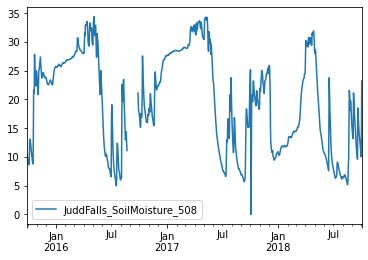

<Figure size 432x288 with 0 Axes>

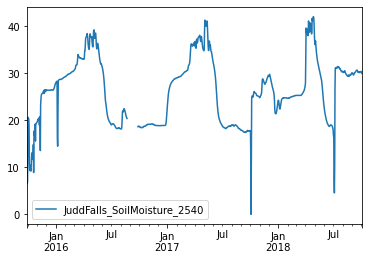

<Figure size 432x288 with 0 Axes>

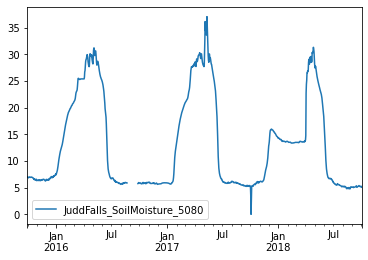

<Figure size 432x288 with 0 Axes>

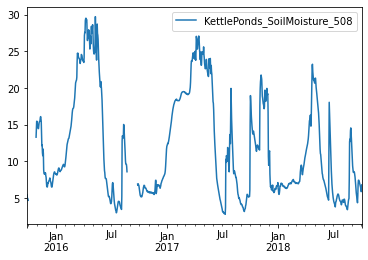

<Figure size 432x288 with 0 Axes>

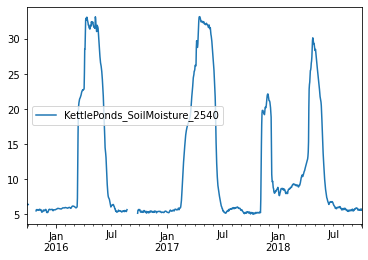

<Figure size 432x288 with 0 Axes>

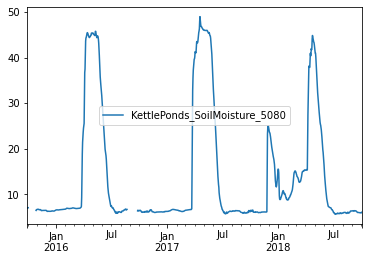

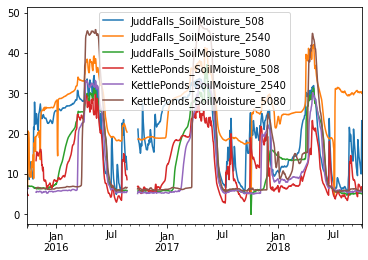

In [33]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilMoisture data should be %

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*100  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'SoilMoisture')      
SoilMoisture = copy.deepcopy(df)
SoilMoisture.plot()

### 12. SoilTemperature

In [34]:
path =os.getcwd().rsplit('/',1)[0]+'/RawData/' + 'SoilTemperature_raw_data/'

In [35]:

ER_CSMWS_soiltemperature_508 = pd.read_csv(path + 'ER_CSMWS_soiltemperature_5.08.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
ER_CSMWS_soiltemperature_508 = ER_CSMWS_soiltemperature_508.drop(ER_CSMWS_soiltemperature_508.columns[[1,2]],axis=1)

ER_CSMWS_soiltemperature_1016 = pd.read_csv(path + 'ER_CSMWS_soiltemperature_10.16.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
# Drop extra columns imported into DataFrame
ER_CSMWS_soiltemperature_1016 = ER_CSMWS_soiltemperature_1016.drop(ER_CSMWS_soiltemperature_1016.columns[[1,2]],axis=1)

ER_CSMWS_soiltemperature_2032 = pd.read_csv(path + 'ER_CSMWS_soiltemperature_20.32.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
# Drop extra columns imported into DataFrame
ER_CSMWS_soiltemperature_2032 = ER_CSMWS_soiltemperature_2032.drop(ER_CSMWS_soiltemperature_2032.columns[[1,2]],axis=1)

ER_CSMWS_soiltemperature_5080 = pd.read_csv(path + 'ER_CSMWS_soiltemperature_50.80.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
# Drop extra columns imported into DataFrame
ER_CSMWS_soiltemperature_5080 = ER_CSMWS_soiltemperature_5080.drop(ER_CSMWS_soiltemperature_5080.columns[[1,2]],axis=1)

ER_CSMWS_soiltemperature_10160 = pd.read_csv(path + 'ER_CSMWS_soiltemperature_101.60.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
# Drop extra columns imported into DataFrame
ER_CSMWS_soiltemperature_10160 = ER_CSMWS_soiltemperature_10160.drop(ER_CSMWS_soiltemperature_10160.columns[[1,2]],axis=1)

ER_CSMWS_soiltemperature = ER_CSMWS_soiltemperature_508.merge(ER_CSMWS_soiltemperature_1016, left_index = True, right_index = True).merge(ER_CSMWS_soiltemperature_2032, left_index = True, right_index = True).merge(ER_CSMWS_soiltemperature_5080, left_index = True, right_index = True).merge(ER_CSMWS_soiltemperature_10160, left_index = True, right_index = True)
ER_CSMWS_soiltemperature.columns = ['5.08', '10.06', '20.32', '50.80', '101.60']



In [36]:

Judd_Falls_soiltemperature_508 = pd.read_csv(path + 'Judd_Falls_soiltemperature_5.08.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
# Drop extra columns imported into DataFrame
Judd_Falls_soiltemperature_508 = Judd_Falls_soiltemperature_508.drop(Judd_Falls_soiltemperature_508.columns[[1,2]],axis=1)

Judd_Falls_soiltemperature_2540 = pd.read_csv(path + 'Judd_Falls_soiltemperature_25.40.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
# Drop extra columns imported into DataFrame
Judd_Falls_soiltemperature_2540 = Judd_Falls_soiltemperature_2540.drop(Judd_Falls_soiltemperature_2540.columns[[1,2]],axis=1)

Judd_Falls_soiltemperature_5080 = pd.read_csv(path + 'Judd_Falls_soiltemperature_50.80.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
# Drop extra columns imported into DataFrame
Judd_Falls_soiltemperature_5080 = Judd_Falls_soiltemperature_5080.drop(Judd_Falls_soiltemperature_5080.columns[[1,2]],axis=1)

Judd_Falls_moisture = Judd_Falls_moisture_508.merge(Judd_Falls_moisture_2540, left_index = True, right_index = True).merge(Judd_Falls_moisture_5080, left_index = True, right_index = True)
Judd_Falls_moisture.columns = ['5.08', '25.40', '50.80']

Judd_Falls_soiltemperature = Judd_Falls_soiltemperature_508.merge(Judd_Falls_soiltemperature_2540, left_index = True, right_index = True).merge(Judd_Falls_soiltemperature_5080, left_index = True, right_index = True)
Judd_Falls_soiltemperature.columns = ['5.08', '25.40', '50.80']

In [37]:
Kettle_Ponds_soiltemperature_508 = pd.read_csv(path + 'Kettle_Ponds_soiltemperature_5.08.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
# Drop extra columns imported into DataFrame
Kettle_Ponds_soiltemperature_508 = Kettle_Ponds_soiltemperature_508.drop(Kettle_Ponds_soiltemperature_508.columns[[1,2]],axis=1)

Kettle_Ponds_soiltemperature_2540 = pd.read_csv(path + 'Kettle_Ponds_soiltemperature_25.40.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
# Drop extra columns imported into DataFrame
Kettle_Ponds_soiltemperature_2540 = Kettle_Ponds_soiltemperature_2540.drop(Kettle_Ponds_soiltemperature_2540.columns[[1,2]],axis=1)

Kettle_Ponds_soiltemperature_5080 = pd.read_csv(path + 'Kettle_Ponds_soiltemperature_50.80.csv',
                    header = 17,index_col = 'datetime',parse_dates = True, infer_datetime_format = True)
# Drop extra columns imported into DataFrame
Kettle_Ponds_soiltemperature_5080 = Kettle_Ponds_soiltemperature_5080.drop(Kettle_Ponds_soiltemperature_5080.columns[[1,2]],axis=1)

Kettle_Ponds_soiltemperature = Kettle_Ponds_soiltemperature_508.merge(Kettle_Ponds_soiltemperature_2540, left_index = True, right_index = True).merge(Kettle_Ponds_soiltemperature_5080, left_index = True, right_index = True)
Kettle_Ponds_soiltemperature.columns = ['5.08', '25.40', '50.80']

Kettle_Ponds_moisture = Kettle_Ponds_moisture_508.merge(Kettle_Ponds_moisture_2540, left_index = True, right_index = True).merge(Kettle_Ponds_moisture_5080, left_index = True, right_index = True)
Kettle_Ponds_moisture.columns = ['5.08', '25.40', '50.80']

In [38]:
df_lst = [ER_CSMWS_soiltemperature_508, ER_CSMWS_soiltemperature_1016, ER_CSMWS_soiltemperature_2032,
          ER_CSMWS_soiltemperature_5080, ER_CSMWS_soiltemperature_10160, Judd_Falls_soiltemperature_508,
           Judd_Falls_soiltemperature_2540, Judd_Falls_soiltemperature_5080,Kettle_Ponds_soiltemperature_508,
          Kettle_Ponds_soiltemperature_2540,Kettle_Ponds_soiltemperature_5080]
column_name = ['ERCSMWS_SoilTemperature_508', 'ERCSMWS_SoilTemperature_1016', 'ERCSMWS_SoilTemperature_2032',
          'ERCSMWS_SoilTemperature_5080', 'ERCSMWS_SoilTemperature_10160', 'JuddFalls_SoilTemperature_508',
           'JuddFalls_SoilTemperature_2540', 'JuddFalls_SoilTemperature_5080','KettlePonds_SoilTemperature_508',
          'KettlePonds_SoilTemperature_2540','KettlePonds_SoilTemperature_5080']
for i,df in enumerate(df_lst):  
    print(i)
    col=column_name[i]
    df.columns=[col]
    df['date'] = [pd.to_datetime(str(k), format='%Y%m%d%H', errors='ignore') for k in df.index]
    df.index = df['date']
    df.index=pd.to_datetime(df.index)
    df.drop(['date'], axis =1,inplace = True)
    df = threC(df,'SoilTemperature') # modify the dataframe and set unphysical values to NAN
    df.index.rename('DateTime',inplace=True)
    display(df.head(2))
    print(df.index[0],df.index[-1])

prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 

0


,ERCSMWS_SoilTemperature_508
DateTime,
2016-09-25 14:50:00,0.0
2016-09-25 15:00:00,0.0


2016-09-25 14:50:00 2018-09-13 00:00:00
1


,ERCSMWS_SoilTemperature_1016
DateTime,
2016-09-25 14:50:00,0.0
2016-09-25 15:00:00,0.0


2016-09-25 14:50:00 2018-09-13 00:00:00
2


,ERCSMWS_SoilTemperature_2032
DateTime,
2016-09-25 14:50:00,0.0
2016-09-25 15:00:00,0.0


2016-09-25 14:50:00 2018-09-13 00:00:00
3


,ERCSMWS_SoilTemperature_5080
DateTime,
2016-09-25 14:50:00,0.0
2016-09-25 15:00:00,0.0


2016-09-25 14:50:00 2018-09-13 00:00:00
4


,ERCSMWS_SoilTemperature_10160
DateTime,
2016-09-25 14:50:00,0.0
2016-09-25 15:00:00,0.0


2016-09-25 14:50:00 2018-09-13 00:00:00
5


,JuddFalls_SoilTemperature_508
DateTime,
2015-09-29 20:40:00,17.93
2015-09-29 21:00:00,17.20


2015-09-29 20:40:00 2018-10-03 00:00:00
6


,JuddFalls_SoilTemperature_2540
DateTime,
2015-09-29 20:40:00,14.385000
2015-09-29 21:00:00,14.523333


2015-09-29 20:40:00 2018-10-03 00:00:00
7


,JuddFalls_SoilTemperature_5080
DateTime,
2015-09-29 20:40:00,13.665000
2015-09-29 21:00:00,13.628333


2015-09-29 20:40:00 2018-10-03 00:00:00
8


,KettlePonds_SoilTemperature_508
DateTime,
2015-09-28 17:10:00,17.802000
2015-09-28 18:00:00,18.796667


2015-09-28 17:10:00 2018-10-03 00:00:00
9


,KettlePonds_SoilTemperature_2540
DateTime,
2015-09-28 17:10:00,11.628000
2015-09-28 18:00:00,11.778333


2015-09-28 17:10:00 2018-10-03 00:00:00
10


,KettlePonds_SoilTemperature_5080
DateTime,
2015-09-28 17:10:00,11.542000
2015-09-28 18:00:00,11.521667


2015-09-28 17:10:00 2018-10-03 00:00:00
['ERCSMWS_SoilTemperature_508', datetime.date(2017, 12, 5)]
nan ratio is 0.08333333333333333 , groupby value is -3.614674242424243
['ERCSMWS_SoilTemperature_2032', datetime.date(2017, 12, 10)]
nan ratio is 0.08333333333333333 , groupby value is -4.161560606060607
The final table is:


,ERCSMWS_SoilTemperature_508,ERCSMWS_SoilTemperature_1016,ERCSMWS_SoilTemperature_2032,ERCSMWS_SoilTemperature_5080,ERCSMWS_SoilTemperature_10160,JuddFalls_SoilTemperature_508,JuddFalls_SoilTemperature_2540,JuddFalls_SoilTemperature_5080,KettlePonds_SoilTemperature_508,KettlePonds_SoilTemperature_2540,KettlePonds_SoilTemperature_5080
2015-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.9396,12.195,11.4753
2015-09-29,NaN,NaN,NaN,NaN,NaN,16.7025,14.5421,13.6542,13.3971,12.4269,11.4992


,ERCSMWS_SoilTemperature_508,ERCSMWS_SoilTemperature_1016,ERCSMWS_SoilTemperature_2032,ERCSMWS_SoilTemperature_5080,ERCSMWS_SoilTemperature_10160,JuddFalls_SoilTemperature_508,JuddFalls_SoilTemperature_2540,JuddFalls_SoilTemperature_5080,KettlePonds_SoilTemperature_508,KettlePonds_SoilTemperature_2540,KettlePonds_SoilTemperature_5080
2018-10-02,NaN,NaN,NaN,NaN,NaN,10.0377,12.6823,12.9197,9.4734,10.4921,10.4107
2018-10-03,NaN,NaN,NaN,NaN,NaN,9.89,12.1,12.58,9.9,10.21,10.24


ERCSMWS_SoilTemperature_508
ERCSMWS_SoilTemperature_1016
ERCSMWS_SoilTemperature_2032
ERCSMWS_SoilTemperature_5080
ERCSMWS_SoilTemperature_10160
JuddFalls_SoilTemperature_508
JuddFalls_SoilTemperature_2540
JuddFalls_SoilTemperature_5080
KettlePonds_SoilTemperature_508
KettlePonds_SoilTemperature_2540
KettlePonds_SoilTemperature_5080


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

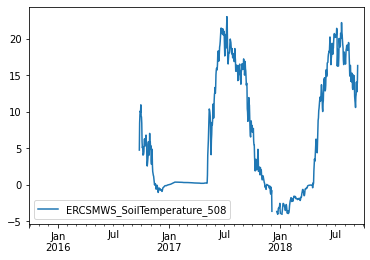

<Figure size 432x288 with 0 Axes>

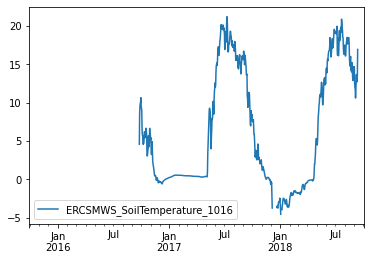

<Figure size 432x288 with 0 Axes>

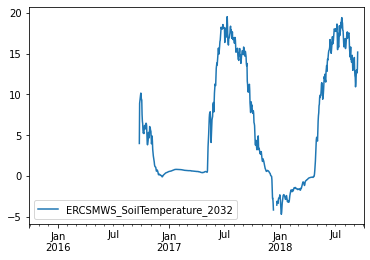

<Figure size 432x288 with 0 Axes>

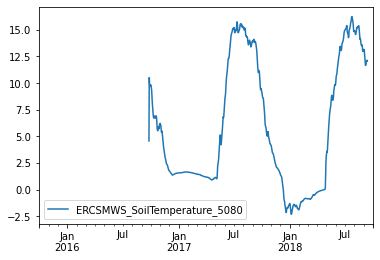

<Figure size 432x288 with 0 Axes>

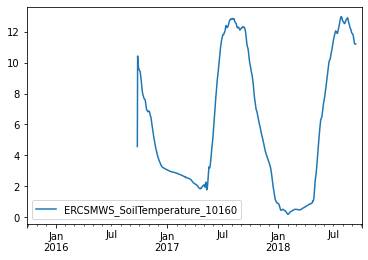

<Figure size 432x288 with 0 Axes>

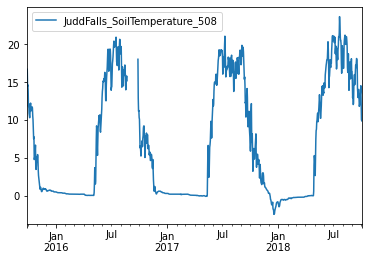

<Figure size 432x288 with 0 Axes>

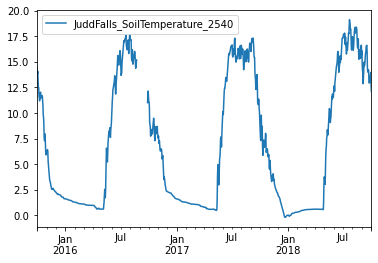

<Figure size 432x288 with 0 Axes>

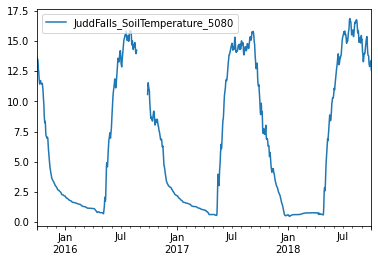

<Figure size 432x288 with 0 Axes>

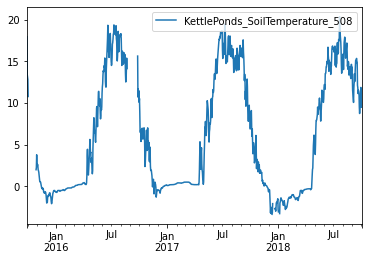

<Figure size 432x288 with 0 Axes>

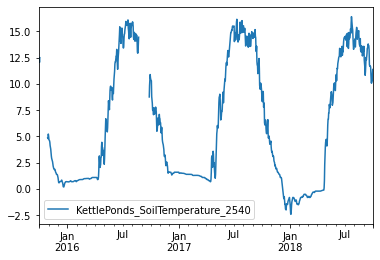

<Figure size 432x288 with 0 Axes>

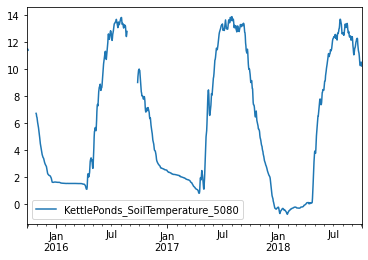

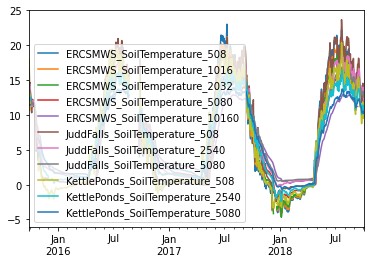

In [39]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SoilTemperature data should be degree celsius

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]) )  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'SoilTemperature')     
SoilTemperature = copy.deepcopy(df)
SoilTemperature.plot()

In [40]:
# 13.Isotope

In [41]:
### Combine all data tables

In [42]:
result = pd.concat([Discharge,Precipitation,AirTemperature,RelativeHumidity, 
                    SnowDepth,SoilMoisture, SoilTemperature],
                    axis=1,join='outer')
result.index.rename('DateTime',inplace = True)
display(result.head())
result.tail()

,Avery_Discharge,Bradley_Discharge,Copper_Discharge,EastQuigley_Discharge,Gothic_Discharge,Marmot_Discharge,PHISCO_Discharge,Quigley_Discharge,Rock_Discharge,Rustlers_Discharge,...,ERCSMWS_SoilTemperature_1016,ERCSMWS_SoilTemperature_2032,ERCSMWS_SoilTemperature_5080,ERCSMWS_SoilTemperature_10160,JuddFalls_SoilTemperature_508,JuddFalls_SoilTemperature_2540,JuddFalls_SoilTemperature_5080,KettlePonds_SoilTemperature_508,KettlePonds_SoilTemperature_2540,KettlePonds_SoilTemperature_5080
DateTime,,,,,,,,,,,,,,,,,,,,,
2014-05-01,NaN,NaN,NaN,NaN,NaN,NaN,4568.230152,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-02,NaN,NaN,NaN,NaN,NaN,NaN,4543.779850,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-03,NaN,NaN,NaN,NaN,NaN,NaN,4977.839947,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-04,NaN,NaN,NaN,NaN,NaN,NaN,6078.289986,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-05,NaN,NaN,NaN,NaN,NaN,NaN,7209.310055,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Avery_Discharge,Bradley_Discharge,Copper_Discharge,EastQuigley_Discharge,Gothic_Discharge,Marmot_Discharge,PHISCO_Discharge,Quigley_Discharge,Rock_Discharge,Rustlers_Discharge,...,ERCSMWS_SoilTemperature_1016,ERCSMWS_SoilTemperature_2032,ERCSMWS_SoilTemperature_5080,ERCSMWS_SoilTemperature_10160,JuddFalls_SoilTemperature_508,JuddFalls_SoilTemperature_2540,JuddFalls_SoilTemperature_5080,KettlePonds_SoilTemperature_508,KettlePonds_SoilTemperature_2540,KettlePonds_SoilTemperature_5080
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-10-12,NaN,NaN,NaN,NaN,NaN,NaN,730.219637,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-13,NaN,NaN,NaN,NaN,NaN,NaN,665.065098,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-14,NaN,NaN,NaN,NaN,NaN,NaN,797.961235,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-15,NaN,NaN,NaN,NaN,NaN,NaN,684.592084,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-16,NaN,NaN,NaN,NaN,NaN,NaN,741.102828,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
result.to_csv('1_EastRiver_Download_Aggregation_Daily.csv', sep=',')

In [44]:
result.columns

Index(['Avery_Discharge', 'Bradley_Discharge', 'Copper_Discharge',
       'EastQuigley_Discharge', 'Gothic_Discharge', 'Marmot_Discharge',
       'PHISCO_Discharge', 'Quigley_Discharge', 'Rock_Discharge',
       'Rustlers_Discharge', '00_Precipitation', '01_Precipitation',
       '02_Precipitation', '10_Precipitation', '11_Precipitation',
       '12_Precipitation', '20_Precipitation', '21_Precipitation',
       '22_Precipitation', 'Castnet_AirTemperature', 'ERCSMWS_AirTemperature',
       'JuddFalls_AirTemperature', 'KettlePonds_AirTemperature',
       'ERCSMWS_RelativeHumidity', 'JuddFalls_RelativeHumidity',
       'ERCSMWS_SnowDepth', 'JuddFalls_SnowDepth',
       'JuddFalls_SoilMoisture_508', 'JuddFalls_SoilMoisture_2540',
       'JuddFalls_SoilMoisture_5080', 'KettlePonds_SoilMoisture_508',
       'KettlePonds_SoilMoisture_2540', 'KettlePonds_SoilMoisture_5080',
       'ERCSMWS_SoilTemperature_508', 'ERCSMWS_SoilTemperature_1016',
       'ERCSMWS_SoilTemperature_2032', 'ERCSMWS_Soi